# Requirements

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from transformers import Trainer,DataCollatorWithPadding
from transformers import TrainingArguments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [5]:
data = pd.read_csv('wine-reviews.csv')
data.sample(3)

,description,points
6703,Savory sage- and cress-like herbal notes mingl...,89
1047,This Mevushal Cab offers tons of dark fruit fl...,85
7679,"This is a dense, rich and soft wine, mostly Ca...",88


## Target Extraction
Extract the target **exceptional** for each wine review. If some wine has at least 90 points it is considered **exceptional**.

In [6]:
# for i in range(len(data)):
#     if data.loc[i]['points'] >= 90:
#         data.iloc[i]['exceptional'] = 1
#     else:
#         data.iloc[i]['exceptional'] = 0

data['exceptional'] = (data['points'] >= 90).astype(int)

In [7]:
data['exceptional'].value_counts()

,count
exceptional,
0,5000
1,5000


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [ ]:
dataset = Dataset.from_pandas(data[['description', 'exceptional']])
dataset = dataset.rename_column("description", "text")
dataset = dataset.rename_column("exceptional", "label")
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_texts = tokenizer(dataset["train"]["text"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=128)

In [ ]:
dataset = dataset.map(tokenize_function, batched=True)
dataset["train"].features

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Define the traning parameters using the `TrainingArguments` class.

In [ ]:
training_args = TrainingArguments(
    output_dir="./trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    metric_for_best_model="f1",
    report_to="none",  # Disables W&B logging
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Define the training using the `Trainer` class.

In [ ]:
import evaluate

metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [ ]:
trainer = Trainer(
    model,
    args = training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Fine-tune (train) the pre-trained lanugage model.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.406600,0.814685,0.764339
2,0.335900,0.575911,0.823227
3,0.213600,0.814063,0.819488


TrainOutput(global_step=3000, training_loss=0.3215643081665039, metrics={'train_runtime': 787.9332, 'train_samples_per_second': 30.459, 'train_steps_per_second': 3.807, 'total_flos': 1578666332160000.0, 'train_loss': 0.3215643081665039, 'epoch': 3.0})

Use the trained model to make predictions for the test set.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.8140634894371033,
 'eval_f1': 0.819488312481828,
 'eval_runtime': 15.1504,
 'eval_samples_per_second': 132.01,
 'eval_steps_per_second': 16.501,
 'epoch': 3.0}

In [ ]:
predictions = trainer.predict(dataset["test"])

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       985
           1       0.83      0.80      0.82      1015

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [10]:
tv = TfidfVectorizer(binary=False, norm='l2', use_idf=False, smooth_idf=False, lowercase=True, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b', min_df=1, max_df=1.0, max_features=None, ngram_range=(1, 1))


In [26]:
X = data['description']
y = data['exceptional']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [28]:
model_reg = LogisticRegression()

In [29]:
model = make_pipeline(tv, model_reg)

In [32]:
model.fit(X_train, Y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(smooth_idf=False, stop_words='english',
                                 token_pattern='(?u)\\b[A-Za-z]+\\b',
                                 use_idf=False)),
                ('logisticregression', LogisticRegression())])

In [35]:
y_pred = model.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1006
           1       0.77      0.79      0.78       994

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



In [36]:
terms = tv.get_feature_names_out()
terms

array(['aaron', 'abadia', 'abbreviated', ..., 'zotovich', 'zucchini',
       'zweigelt'], dtype=object)

In [40]:
coef = model_reg.coef_[0]
pos = np.argsort(coef)[-10:]
neg = np.argsort(coef)[:10]

In [41]:
top_positive_terms = [(terms[i], coef[i]) for i in pos]
top_negative_terms = [(terms[i], coef[i]) for i in neg]

In [42]:
keywords_df = pd.DataFrame({
    'Positive Terms': [t[0] for t in top_positive_terms],
    'Positive Coefficients': [t[1] for t in top_positive_terms],
    'Negative Terms': [t[0] for t in top_negative_terms],
    'Negative Coefficients': [t[1] for t in top_negative_terms]
})

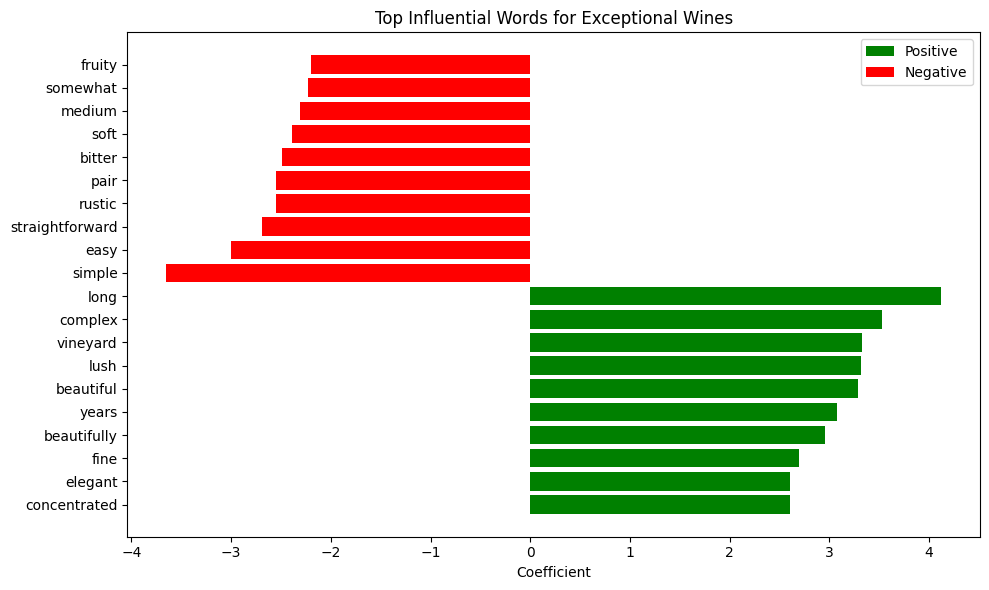

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    [t[0] for t in top_positive_terms],
    [t[1] for t in top_positive_terms],
    color='green',
    label='Positive'
)
plt.barh(
    [t[0] for t in top_negative_terms],
    [t[1] for t in top_negative_terms],
    color='red',
    label='Negative'
)
plt.xlabel('Coefficient')
plt.title('Top Influential Words for Exceptional Wines')
plt.legend()
plt.tight_layout()
plt.show()